In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import numpy as np
from random import random
from numpy import mean

import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pytorch_lightning as pl
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms

from pytorch_lightning import loggers as pl_loggers


### Reading data

In [11]:
train_test = pd.read_csv('train_test.csv')
train_test.head()

/Users/arushi/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date,store_nbr,item_nbr,unit_sales,onpromotion,id
0,2013-01-01,25,103665,7.0,NaN,NaN
1,2013-01-01,25,105574,1.0,NaN,NaN
2,2013-01-01,25,105575,2.0,NaN,NaN
3,2013-01-01,25,108079,1.0,NaN,NaN
4,2013-01-01,25,108701,1.0,NaN,NaN


In [12]:
train_test.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,id
0,2013-01-01,25,103665,7.0,NaN,NaN
1,2013-01-01,25,105574,1.0,NaN,NaN
2,2013-01-01,25,105575,2.0,NaN,NaN
3,2013-01-01,25,108079,1.0,NaN,NaN
4,2013-01-01,25,108701,1.0,NaN,NaN


In [74]:
train_data = pd.read_csv('data/train.csv')
train_data.head()

/Users/arushi/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date,store_nbr,item_nbr,unit_sales,onpromotion
0,2013-01-01,25,103665,7.0,NaN
1,2013-01-01,25,105574,1.0,NaN
2,2013-01-01,25,105575,2.0,NaN
3,2013-01-01,25,108079,1.0,NaN
4,2013-01-01,25,108701,1.0,NaN


### Reading the supplementary files

In [13]:
oil = pd.read_csv('data/oil.csv')
holidays = pd.read_csv('data/holidays_events.csv')
items = pd.read_csv('data/items.csv')

### Data Preprocessing

In [14]:
def cartesian(df1, df2):
    """Determine Cartesian product of two data frames."""
    key = 'key'
    while key in df1.columns or key in df2.columns:
        key = '_' + key
    key_d = {key: 0}
    return pd.merge(
        df1.assign(**key_d), df2.assign(**key_d), on=key).drop(key, axis=1)

In [22]:
def data_preprocessing(df, holidays_events_df, oil_df, item_df, lag_days = [1,7,30], rolling_days = [7,30,60]):

    # filter out items who has been sold for less than 1600 days
    item_count = df.groupby('item_nbr')['unit_sales'].count()
    items_to_keep = item_count[item_count > 1000].index
    df = df.loc[df['item_nbr'].isin(items_to_keep)]

    start_date = pd.to_datetime(df['date'].agg(['min', 'max'])['min'])
    end_date = pd.to_datetime(df['date'].agg(['min', 'max'])['max'])
    date_df = pd.DataFrame()
    date_df['date'] = pd.date_range(start=start_date, end= end_date)
    date_df['date'] = pd.to_datetime(date_df['date'])
    unique_store_df = pd.DataFrame({'store_nbr' : df['store_nbr'].unique()})
    unique_item_df = pd.DataFrame({'item_nbr' : df['item_nbr'].unique()})
      
    date_df = cartesian(date_df, unique_store_df)
    date_df = cartesian(date_df, unique_item_df)

    df['date'] = pd.to_datetime(df['date'])
    df = date_df.merge(df, how = 'left', on = ['date', 'store_nbr', 'item_nbr'])

    
    # filling NA values in onpromotion and doing one-hot encoding
    df['onpromotion'] = df['onpromotion'].fillna("Not Mentioned")
    df_promo = pd.get_dummies(df['onpromotion'])
    df_promo = df_promo.rename(columns={True: "promoted", False: "not_promoted"})
    df = pd.concat([df, df_promo], axis = 1)
    df = df.drop(['onpromotion'], axis=1)
    
    # creating date features
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_month'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_year'] = df['date'].dt.dayofyear
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['is_weekend'] = (df['day_of_week']>=5).astype(np.int8)

    # Handling nan values Unit sales 
    df['unit_sales'] = df.groupby(['store_nbr', 'item_nbr', 'day_of_week'])['unit_sales'].ffill()
    df['unit_sales'] = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(lambda x: x.fillna(x.mean()))


    # creating Lag features
    SHIFT = 15
    for l in lag_days:
        df['lag_{}'.format(l)] = df.groupby(['store_nbr', 'item_nbr', 'day_of_week'])['unit_sales'].transform(lambda x: x.shift(SHIFT+l))

    # Rolling features
    for r in rolling_days:
        df['rolling_mean_{}'.format(r)] = df.groupby(['store_nbr', 'item_nbr', 'day_of_week'])['unit_sales'].transform(lambda x: x.shift(SHIFT).rolling(r, min_periods = 1).mean())

    
    # merging oil_df and getting oil prices from that
    oil_df['date'] = pd.to_datetime(oil_df['date'])
    oil_df = oil_df.rename(columns={"dcoilwtico": "oil_price"})
    df = df.merge(oil_df, how = 'left', on = 'date')
    
    # Filling the missing values of oil prices from the price of the previous row
    df['oil_price'] = df["oil_price"].fillna(axis = 0,method = 'ffill')
    # To fill the oil prices for first day, we will copy the mean price from the second day.
    oil_price = df[df.date == '2013-01-02']['oil_price']
    oil_price = round(np.mean(oil_price), 2)
    df['oil_price'] = df['oil_price'].fillna(oil_price)


    # merging holiday_df
    holidays_events_df['date'] = pd.to_datetime(holidays_events_df['date'])
    holidays_events_df['type'] = holidays_events_df['type'].replace(['Additional','Bridge','Event', 'Transfer'], 'Holiday')
    holidays_events_df = holidays_events_df.drop(['locale', 'locale_name','description','transferred'], axis=1)
    holidays_events_df = holidays_events_df.rename(columns={"type": "day_type"})
    df = df.merge(holidays_events_df[['date', 'day_type']], how = 'left', on = 'date')
    df['day_type'].fillna(False, inplace = True)
    df['day_type'] = df['day_type'].astype(bool).astype(int)

    # merging items to include item family
    item_df = item_df[['item_nbr', 'family']]
    item_df['family'] = item_df['family'].replace(['HOME AND KITCHEN I','HOME AND KITCHEN II','CELEBRATION',
                                             'AUTOMOTIVE', 'LINGERIE', 'GROCERY II', 'SEAFOOD',
                                             'PLAYERS AND ELECTRONICS', 'LADIESWEAR', 'BEAUTY', 'PET SUPPLIES',
                                            'LAWN AND GARDEN', 'MAGAZINES', 'HARDWARE',
                                             'SCHOOL AND OFFICE SUPPLIES', 'HOME APPLIANCES', 'BABY CARE',
                                            'BOOKS'], 'Others')
    family_df = pd.get_dummies(item_df['family'])
    item_df = pd.concat([item_df, family_df], axis = 1)
    df = pd.merge(df, item_df, on = 'item_nbr', how = 'left')
    df = df.drop(['item_nbr', 'store_nbr', 'family'], axis=1)

    return df

### Filtering data based on store

In [23]:
# Select the store for which you want to predict unit sales 

selected_store = train_test.loc[train_test['store_nbr'] == 3]

In [24]:
selected_store.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion,id
2699,2013-01-02,3,103665,6.0,NaN,NaN
2700,2013-01-02,3,105574,36.0,NaN,NaN
2701,2013-01-02,3,105575,21.0,NaN,NaN
2702,2013-01-02,3,105577,6.0,NaN,NaN
2703,2013-01-02,3,105693,2.0,NaN,NaN


In [25]:
data = data_preprocessing(selected_store, holidays, oil, items, lag_days = [1,7,30], rolling_days = [7,30,60])
data.head()

/Users/arushi/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/arushi/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,date,unit_sales,id,not_promoted,promoted,Not Mentioned,day_of_month,day_of_week,day_of_year,month,...,FROZEN FOODS,GROCERY I,HOME CARE,"LIQUOR,WINE,BEER",MEATS,Others,PERSONAL CARE,POULTRY,PREPARED FOODS,PRODUCE
0,2013-01-02,6.0,NaN,0,0,1,2,2,2,1,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,36.0,NaN,0,0,1,2,2,2,1,...,0,1,0,0,0,0,0,0,0,0
2,2013-01-02,21.0,NaN,0,0,1,2,2,2,1,...,0,1,0,0,0,0,0,0,0,0
3,2013-01-02,6.0,NaN,0,0,1,2,2,2,1,...,0,1,0,0,0,0,0,0,0,0
4,2013-01-02,2.0,NaN,0,0,1,2,2,2,1,...,0,1,0,0,0,0,0,0,0,0


In [26]:
len(data)

2365712

In [132]:
data.isnull().sum().sort_values(ascending=False)

id                  1958904
lag_30               396198
lag_7                192510
lag_1                139104
rolling_mean_60      130410
rolling_mean_7       130410
rolling_mean_30      130410
day_of_month              0
day_of_week               0
PREPARED FOODS            0
month                     0
year                      0
is_weekend                0
Not Mentioned             0
promoted                  0
not_promoted              0
unit_sales                0
day_of_year               0
PRODUCE                   0
oil_price                 0
GROCERY I                 0
POULTRY                   0
PERSONAL CARE             0
Others                    0
MEATS                     0
LIQUOR,WINE,BEER          0
HOME CARE                 0
FROZEN FOODS              0
day_type                  0
EGGS                      0
DELI                      0
DAIRY                     0
CLEANING                  0
BREAD/BAKERY              0
BEVERAGES                 0
date                

In [27]:
data = data.loc[(data['date'] > pd.datetime(2014,1,1)) & (data['date'] < pd.datetime(2017,5,1))]
data = data.drop(['id'], axis = 1)

/Users/arushi/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [28]:
data.isna().sum()

date                0
unit_sales          0
not_promoted        0
promoted            0
Not Mentioned       0
day_of_month        0
day_of_week         0
day_of_year         0
month               0
year                0
is_weekend          0
lag_1               0
lag_7               0
lag_30              0
rolling_mean_7      0
rolling_mean_30     0
rolling_mean_60     0
oil_price           0
day_type            0
BEVERAGES           0
BREAD/BAKERY        0
CLEANING            0
DAIRY               0
DELI                0
EGGS                0
FROZEN FOODS        0
GROCERY I           0
HOME CARE           0
LIQUOR,WINE,BEER    0
MEATS               0
Others              0
PERSONAL CARE       0
POULTRY             0
PREPARED FOODS      0
PRODUCE             0
dtype: int64

### Diving the data into train, validation and test based on dates

In [29]:
data['date'] = pd.to_datetime(data['date'])
train_startdate = data['date'] >= '2014-01-01'
train_enddate = data['date'] <= '2016-12-31'
train_duration = train_startdate & train_enddate
traindata = data.loc[train_duration]

val_startdate = data['date'] >= '2017-01-01'
val_enddate = data['date'] <= '2017-03-31'
val_duration = val_startdate & val_enddate
val_data = data.loc[val_duration]

test_startdate = data['date'] >= '2017-04-01'
test_enddate = data['date'] <= '2017-04-15'
test_duration = test_startdate & test_enddate
test_data = data.loc[test_duration]


In [30]:
traindata.head()

,date,unit_sales,not_promoted,promoted,Not Mentioned,day_of_month,day_of_week,day_of_year,month,year,...,FROZEN FOODS,GROCERY I,HOME CARE,"LIQUOR,WINE,BEER",MEATS,Others,PERSONAL CARE,POULTRY,PREPARED FOODS,PRODUCE
549820,2014-01-02,10.0,0,0,1,2,3,2,1,2014,...,0,0,0,0,0,0,0,0,0,0
549821,2014-01-02,24.0,0,0,1,2,3,2,1,2014,...,0,1,0,0,0,0,0,0,0,0
549822,2014-01-02,33.0,0,0,1,2,3,2,1,2014,...,0,1,0,0,0,0,0,0,0,0
549823,2014-01-02,9.0,0,0,1,2,3,2,1,2014,...,0,1,0,0,0,0,0,0,0,0
549824,2014-01-02,3.0,0,0,1,2,3,2,1,2014,...,0,1,0,0,0,0,0,0,0,0


In [43]:
traindata.columns

Index(['date', 'unit_sales', 'not_promoted', 'promoted', 'Not Mentioned',
       'day_of_month', 'day_of_week', 'day_of_year', 'month', 'year',
       'is_weekend', 'lag_1', 'lag_7', 'lag_30', 'rolling_mean_7',
       'rolling_mean_30', 'rolling_mean_60', 'oil_price', 'day_type',
       'BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'HOME CARE', 'LIQUOR,WINE,BEER', 'MEATS',
       'Others', 'PERSONAL CARE', 'POULTRY', 'PREPARED FOODS', 'PRODUCE'],
      dtype='object')

### Creating features for Baseline and Regression

In [31]:
y_train = traindata.unit_sales
X_train = traindata.drop(['unit_sales', 'date'], axis=1)

y_val = val_data.unit_sales
X_val = val_data.drop(['unit_sales', 'date'], axis=1)

y_test = test_data.unit_sales
X_test = test_data.drop(['unit_sales', 'date'], axis=1)


## Modeling

#### Defining performance metrics

In [32]:
def get_model_performance(y_test, y_pred):

    mae = round(metrics.mean_absolute_error(y_test, y_pred), 2)
    mse = round(metrics.mean_squared_error(y_test, y_pred), 2)
    rmse = round(np.sqrt(mse), 2)
    r2 = round(metrics.r2_score(y_test,y_pred), 2)  
    print(f" MAE is {mae}\n MSE is {mse} \n RMSE is {rmse} \n R square is {r2} \n")
  
def get_mape_wape(y_test, y_pred):
    pred_df = pd.DataFrame({'target' : y_test, 'pred' : y_pred})
    pred_df['weight'] = pred_df['target']/ sum(pred_df['target'])
    pred_df['mape'] = abs(pred_df['target'] - pred_df['pred'])/pred_df['target']
    pred_df['wmape'] = pred_df['weight']*pred_df['mape']
    mape = round(pred_df['mape'].mean() * 100, 4)
    wmape = round(pred_df['wmape'].sum()*100, 4)
    return mape, wmape

### Moving Average ( Baseline)

In [47]:
type(y_test)

pandas.core.series.Series

In [46]:
window = 7
print(y_train[1])
history = [y_train[i] for i in range(window)]
test = [y_test[i] for i in range(window, len(y_test))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)

error = get_model_performance(test, predictions)

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()
# zoom plot
plt.plot(test[0:100])
plt.plot(predictions[0:100], color='red')
plt.title("Actual vs Prediction on Baseline")
plt.xlabel("First 100 predictions")
plt.ylabel("Unit Sales")
plt.show()

KeyError: 1

### SGD

In [48]:
sgd_reg = make_pipeline(StandardScaler(),SGDRegressor(max_iter=1000, tol=1e-3))
sgd_reg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

In [50]:
sgd_pred = sgd_reg.predict(X_test)
get_model_performance(y_test, sgd_pred)
mape, wmape = get_mape_wape(y_test, sgd_pred)
print(f"MAPE is {mape}, WMAPE is {wmape}")

 MAE is 5.76
 MSE is 172.05 
 RMSE is 13.12 
 R square is 0.57 

MAPE is 76.7786, WMAPE is 44.5987


### LSTM

In [143]:
# Drop date and convert dataframes to list of lists
traindata = traindata.drop(['date'], axis=1)
val_data = val_data.drop(['date'], axis=1)
test_data = test_data.drop(['date'], axis=1)

train_list = traindata.values.tolist()
val_list = val_data.values.tolist()
test_list = test_data.values.tolist()

#### Defning Model

In [173]:

class LSTMModel(pl.LightningModule):
    def __init__(self, input_size=33, hidden_size=50, output_size=1, num_layers=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers)
        self.linear = nn.Linear(self.hidden_size, self.output_size)


    def forward(self, x):
        x = torch.unsqueeze(x, dim=0) # 32x26x1 (seq_len * batch_size * input_size)
        _, (h_n, _) = self.lstm(x)  # 26x50x1 (input_size * hidden_size * num_layers)
        h_n = torch.squeeze(h_n)
        h_n = F.relu(h_n) 
        h_n = self.linear(h_n)
        return h_n
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()
        train_loss = loss(torch.flatten(y_hat), y)
        self.log("Train loss", train_loss, prog_bar=True, on_epoch=True)
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat = torch.flatten(y_hat)
        loss = nn.MSELoss()
        val_loss = loss(y_hat, y)
        self.log("Validation loss", val_loss, prog_bar=True, on_epoch=True)
        
        return {'y': y, 'y_hat': y_hat}
    
    
    def validation_epoch_end(self, validation_step_outputs):
        
        y_test, y_pred = [], []
        
        for val_step_op in validation_step_outputs:
            y_test.extend(val_step_op['y'].tolist())
            y_pred.extend(val_step_op['y_hat'].tolist())
                 
        mape, wape = get_mape_wape(y_test, y_pred)
        self.log("Val epoch mape", mape, prog_bar= True, on_epoch=True)
        self.log("Val epoch wape", wape, prog_bar= True, on_epoch=True)
            
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()
        test_loss = loss(torch.flatten(y_hat), y)
        self.log("Test loss", test_loss, prog_bar=True, on_epoch=True)
        return test_loss
    
    
    def test_epoch_end(self, test_step_outputs):
        
        y_test, y_pred = [], []
        
        for val_step_op in validation_step_outputs:
            y_test.extend(val_step_op['y'].tolist())
            y_pred.extend(val_step_op['y_hat'].tolist())
                 
        mape, wape = get_mape_wape(y_test, y_pred)
        self.log("Val epoch mape", mape, prog_bar= True, on_epoch=True)
        self.log("Val epoch wape", wape, prog_bar= True, on_epoch=True)

#### Create dataloader

In [174]:
def collate_fn(batch):
    labels = []
    features = []
    for row in batch:
        labels.append(row[0])
        features.append(row[1:])
    return torch.Tensor(features), torch.Tensor(labels)


train_dl = DataLoader(train_list, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_list, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_dl = DataLoader(test_list, batch_size=32, shuffle=False, collate_fn=collate_fn)


#### Training Model

In [ ]:
tb_logger = pl_loggers.TensorBoardLogger("logs/")

model = LSTMModel()
trainer = pl.Trainer(logger=tb_logger)
trainer.fit(model, train_dl, val_dl)
trainer.test(model, test_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type   | Params
----------------------------------
0 | lstm   | LSTM   | 17.0 K
1 | linear | Linear | 51    
----------------------------------
17.1 K    Trainable params
0         Non-trainable params
17.1 K    Total params
0.068     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Aggregating the results from different Models

Text(0, 0.5, 'Mean Absolute Percentage Error')

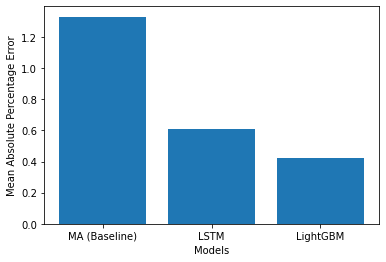

In [7]:
x = ['MA (Baseline)', 'LSTM', 'LightGBM']
y = [1.33, 0.606, 0.423]

plt.bar(x, y)
plt.xlabel("Models")
plt.ylabel("Mean Absolute Percentage Error")
